Test example:  1/45 | Predicted: 0 | Actual: 0 | Match: True
Test example: 11/45 | Predicted: 0 | Actual: 0 | Match: True
Test example: 21/45 | Predicted: 2 | Actual: 2 | Match: True
Test example: 31/45 | Predicted: 0 | Actual: 0 | Match: True
Test example: 41/45 | Predicted: 0 | Actual: 0 | Match: True

		38 matches out of 45 examples
		Test set accuracy: 0.8444



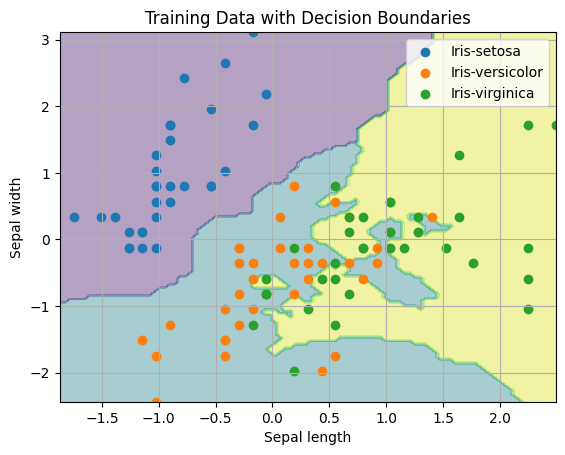

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class KNN:
    def __init__(self, nb_features, nb_classes, data, k, weighted=False):
        self.nb_features = nb_features
        self.nb_classes = nb_classes
        self.k = k
        self.weighted = weighted
        self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
        self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)

    def predict(self, query_data):
        nb_queries = len(query_data['x'])
        matches = 0
        predicted_labels = []

        for i in range(nb_queries):
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_data['x'][i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)
            classes = tf.gather(self.Y, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / dists
            else:
                w = tf.fill([self.k], 1/self.k)

            w_col = tf.reshape(w, (self.k, 1))
            classes_one_hot = tf.one_hot(classes, self.nb_classes)
            scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)
            hyp = tf.argmax(scores)

            if 'y' in query_data:
                actual = query_data['y'][i]
                match = (hyp == actual)
                if match:
                    matches += 1
                if i % 10 == 0:
                    print(f'Test example: {i+1:2}/{nb_queries} | Predicted: {hyp} | Actual: {actual} | Match: {match}')
            predicted_labels.append(hyp.numpy())

        if 'y' in query_data:
            accuracy = matches / nb_queries
            print(f'\n\t\t{matches} matches out of {nb_queries} examples')
            print(f'\t\tTest set accuracy: {accuracy:.4f}\n')

        return predicted_labels

# --------------------------------------------------------- #
tadija_path = '/content/drive/MyDrive/ML2024_D1/iris.csv'
mina_path = '/content/drive/MyDrive/6003 ML/data/iris.csv'
# --------------------------------------------------------- #

data = dict()
data['x'] = np.loadtxt(tadija_path, delimiter=',', skiprows=1, usecols=(0, 1), dtype='float32')
data['y'] = np.loadtxt(tadija_path, delimiter=',', skiprows=1, usecols=(4), dtype='U20')

unique_values = np.unique(data['y'])

y_mapping = dict()
for i in range(len(unique_values)):
    y_mapping[unique_values[i]] = i

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)

# Deljenje podataka 70:30
index_70_percent = int(len(data['x']) * 0.7)
train_data, test_data = dict(), dict()

train_data['x'] = data['x'][:index_70_percent]
train_data['y'] = [y_mapping[string] for string in data['y'][:index_70_percent]]

test_data['x'] = data['x'][index_70_percent:]
test_data['y'] = [y_mapping[string] for string in data['y'][index_70_percent:]]

# -----

train_data['x'] = np.reshape(train_data['x'], [len(train_data['x']), -1])
test_data['x'] = np.reshape(test_data['x'], [len(test_data['x']), -1])

nb_features = 2
nb_classes = len(unique_values)
k = 3

knn = KNN(nb_features, nb_classes, train_data, k, weighted=False)
knn.predict(test_data)

# Overlaying decision boundaries
xx, yy = np.meshgrid(np.linspace(data['x'][:, 0].min(), data['x'][:, 0].max(), 100),
                     np.linspace(data['x'][:, 1].min(), data['x'][:, 1].max(), 100))
Z = knn.predict({'x': np.c_[xx.ravel(), yy.ravel()]})
Z = np.array(Z).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

# Plotting the training data with different colors for each class
for category in np.unique(train_data['y']):
    mask = (train_data['y'] == category)
    label = unique_values[category]  # Get the string label for visualization
    plt.scatter(train_data['x'][mask][:, 0], train_data['x'][mask][:, 1], label=label)

# Set legend with string labels
handles, labels = plt.gca().get_legend_handles_labels()
label_mapping = {i: label for i, label in enumerate(labels)}
unique_labels = sorted(label_mapping.keys())
plt.legend([handles[i] for i in unique_labels], [label_mapping[i] for i in unique_labels])

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Training Data with Decision Boundaries')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
